# CF01: PDE-based Bayesian Problems using CUQIpy and CUQIpy-FEniCS plugin

Here we build a Bayesian inverse problem to infer the conductivity in a 2D unit-square domain modelled by the Poisson equation (applications include EIT problems).

The PDE model is built using FEniCS, then we use CUQIpy-FEniCS to wrap the PDE model to interface it with CUQIpy. We use CUQIpy samplers to solve the PDE-based Bayesian problem.

## Learning objectives of this notebook:
- Build a FEniCS-based Poisson problem
- Build and solve the corresponding PDE-based Bayesian problem in CUQIpy
	- Use Matern covariance to specify the prior
	- Use pCN sampler
- Use gradient-based sampler
	- Identify the chain rule needed to compute the gradient of the log-likelihood
	- Use NUTS sampler

## Table of contents
1. [Building a FEniCS based Poisson problem](#PDEproblem)
2. [Building and solving the PDE-based Bayesian problem in CUQIpy](#Bayesian_problem)
3. [Using gradient-based sampler](#gradient_sampling)


## Import required libraries and classes

In [1]:
from scipy import optimize
import ufl
import matplotlib.pyplot as plt
import dolfin as dl
import numpy as np
from cuqi.model import PDEModel
from cuqi.distribution import Gaussian, Posterior
from cuqi.array import CUQIarray
from cuqipy_fenics.pde import SteadyStateLinearFEniCSPDE
from cuqipy_fenics.geometry import FEniCSContinuous, MaternKLExpansion
from cuqi.sampler import NUTS, pCN


## 1. Building a FEniCS based Poisson problem <a class="anchor" id="PDEproblem"></a>

In this section, we use FEniCS python library to build a PDE model. 

The PDE model we consider here is a 2D steady-state problem (Poisson):

\begin{align*}
 -\nabla \cdot \left(\kappa(\xi) \nabla u(\xi)\right) &= f(\xi) \;\;\;\;\xi=[\xi^1, \xi^2]^\mathrm{T} \in (0,1)\times(0,1),\\
u(\xi)&=0 \;\;\;\;\mathrm{on}\; \xi^1=0\\
u(\xi)&=0 \;\;\;\;\mathrm{on}\; \xi^1=1 \\
\kappa(\xi)\nabla u(\xi)\cdot n&=0 \;\;\;\;\mathrm{on}\; \xi^2=0 \\
\kappa(\xi)\nabla u(\xi)\cdot n&=0 \;\;\;\;\mathrm{on}\; \xi^2=1 
\end{align*}



- where $\kappa(\xi)$ is the conductivity, $u(\xi)$ is the PDE solution (potential), $f(\xi)$ is the source term.

- We use the parameterization $\kappa(\xi) = e^{m(\xi)}$, to ensure positivity of the inferred conductivity (more on this later).

- We denote the discretized system that we need to solve as
$\mathbf{A}(\mathbf{m})\mathbf{U} = \mathbf{F}$
  - $\mathbf{A}$ is the discretized diffusion differential operator
  - $\mathbf{m}$ is the discretized unknown parameter (log conductivity) 
  - $\mathbf{U}$ is the discretized solution (the potential)
  - $\mathbf{F}$ is the discretized RHS (the source term) 

### The discretization 

We use finite element discretization of the model above where the solution and the parameters are approximated in a second and first order Lagrange polynomial space, respectively. 

Using finite element formulation requires building the weak form of the PDE. To formulate the weak form, we multiply the PDE by a test function and integrate by parts and substitute the Neumann boundary conditions above (the last two equations above).

For formulating the weak form, see for example [this reference](https://en.wikiversity.org/wiki/Finite_elements/Weak_form_of_Poisson_equation).

### 1.1. Set up mesh

We create a 2D FEniCS mesh (unit square mesh) on which the finite element solution is discretized.

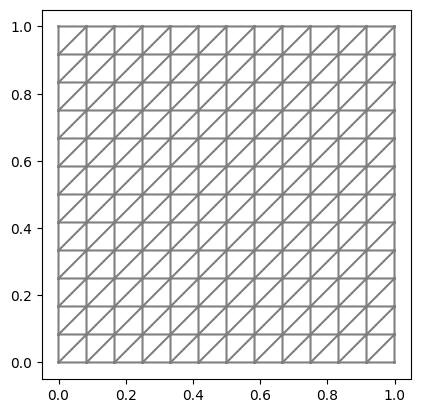

In [2]:
n_ksi_1 = 12 # number of vertices on the ksi_1 dimension
n_ksi_2 = 12 # number of vertices on the ksi_2 dimension
mesh = dl.UnitSquareMesh(n_ksi_1, n_ksi_2) # create FEniCS mesh
dl.plot(mesh)

### 1.2. Set up function spaces

We define the function spaces on which the PDE solution $u$ and the quantity we want to quantify (log conductivity $m$) are discretized. The function spaces are, respectively, second order Lagrange polynomial space and first order Lagrange polynomial space.

In [3]:
solution_function_space = dl.FunctionSpace(mesh, 'Lagrange', 2) # function space for solution u
parameter_function_space = dl.FunctionSpace(mesh, 'Lagrange', 1) # function space for parameter m

### 1.3. Set up Dirichlet boundary conditions 

We create the Dirichlet boundary conditions: 
\begin{align*}
u(\xi)&=0 \;\;\;\;\mathrm{on}\; \xi^1=0\\
u(\xi)&=0 \;\;\;\;\mathrm{on}\; \xi^1=1 \\
\end{align*}

In [4]:
# Function (where do we have Dirichlet BC)
def u_boundary(ksi, on_boundary):
    return on_boundary and ( ksi[0] < dl.DOLFIN_EPS or ksi[0] > 1.0 - dl.DOLFIN_EPS)

# Expression (what is the value on these Dirichlet BC)
dirichlet_bc_expr = dl.Expression("0", degree=1)

# FEniCS Dirichlet BC Object
dirichlet_bc = dl.DirichletBC(solution_function_space,
                              dirichlet_bc_expr,
                              u_boundary) 

### 1.4. Set up source term

We set the source term $f(\xi)$ to a constant value 1.

In [5]:
f = dl.Constant(1.0)

### 1.5. Set up PDE variational form

After parametrizing conductivity using $\kappa(\xi) = e^{m(\xi)}$, the variational form of the Poisson PDE above is:

\begin{align*}
\int_{(0,1)\times(0,1)} \left( e^{m(\xi)} \nabla u(\xi) \cdot \nabla p(\xi)  - f(\xi)p(\xi) \right){d\xi}
\end{align*}

where $p(\xi)$ is a test function. We create a function that takes the unknown parameters `m`, and a representation of the solution function `u` and a test function `p` and returns the weak form.



In [6]:
# FEniCS measure for integration
dksi = dl.Measure('dx', domain=mesh)

# The weak form of the PDE
def form(m,u,p):
    return ufl.exp(m)*ufl.inner(ufl.grad(u), ufl.grad(p))*dksi - f*p*dksi

### 1.6 Create CUQIpy PDE object

We bundle the FEniCS PDE model that we built in a `SteadyStateLinearFEniCSPDE` object:

In [7]:
PDE = SteadyStateLinearFEniCSPDE( 
        form,
        mesh, 
        parameter_function_space=parameter_function_space,
        solution_function_space=solution_function_space,
        dirichlet_bcs=dirichlet_bc)

Let us try solving this PDE for $m(\xi)=1$, first we create the parameter:

In [8]:
# Create homogeneous parameter m_1(ksi) = 1

# Create a FEniCS function for the parameter
m_1 = dl.Function(parameter_function_space)

# Assign the value 1 to the FEniCS function by interpolating a FEniCS Constant object.
m_1.interpolate(dl.Constant(1.0))

Let us check `m_1` value at a given point (0.5, 0.8)

In [9]:
m_1(.5, .8)

1.0

Now let us use the object we created `PDE` to assemble (build the discretized linear system) and solve the PDE

In [10]:
# Assemble the PDE at m_1
PDE.assemble(m_1)

# Solve the PDE at m_1
u, _ = PDE.solve()

Plot the solution 


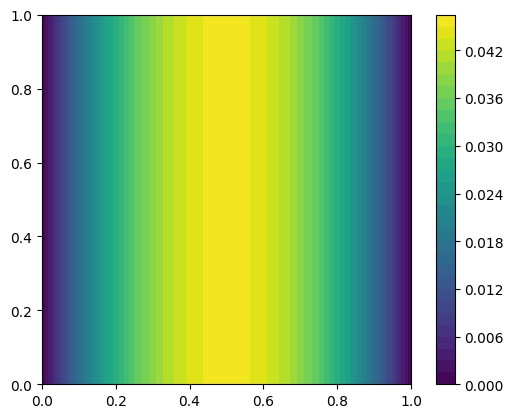

In [11]:
im = dl.plot(u)
plt.colorbar(im)

## 2. Building and solving the Bayesian inverse problem in CUQIpy <a class="anchor" id="Bayesian_problem"></a>
  
The goal is to infer the log conductivity profile $m(\xi)$ given observed data $y^\mathrm{obs}$. These observation can be of the potential directly, i.e. $y^\mathrm{obs}=u(\xi)$, or a function of the potential. 

The data $y^\mathrm{obs}$ is then given by:

$$ y^\mathrm{obs} = \mathcal{G}(m) + \eta$$


where 
- $\eta$ is the measurement noise
- $\mathcal{G}$ is the forward model operator which maps $m$ to the observations.


### 2.1. Create domain geometry 
We model $m$ as a Matern-class random field which lead to the parametrization (Karhunen-Loève (KL) expansion):
$$
    m(\xi) = \sum_{i=0}^{\infty} \sqrt{\lambda_i}x_i e_i(\xi) \approx \sum_{i=0}^{n_\mathrm{KL}} \sqrt{\lambda_i}x_i e_i(\xi)
$$
- $ \lambda_i $ and $ e_i $ are the eigenvalues and eigenvectors of the Matern covariance  operator.
- $n_\mathrm{KL}$ is the number of KL terms used to approximate the random field $m(\xi)$ (we choose $n_\mathrm{KL}=32$ here).
- $x_i\sim \mathrm{Gaussain}(0,1)$ are i.i.d. standard normal random variables.
- Now, $x_i$ are the unknown parameters that parameterize the conductivity field $m(\xi)$.

To define the Matern field (which represents the domain of our forward model), we use `MaternKLExpansion` and define the field as follows:

In [12]:
# Define CUQI geometry on which m is defined
fenics_continuous_geo = FEniCSContinuous(parameter_function_space,
                                         labels=['$\\xi_1$', '$\\xi_2$'])

# Define the MaternExpansion geometry that maps the i.i.d random variables to
# Matern field realizations
domain_geometry = MaternKLExpansion(fenics_continuous_geo,
                                    length_scale=.1,
                                    num_terms=32)

### 2.2. Create range geometry

We create the range geometry which represents the forward model output (the solution $u$ in the entire domain in this case) 

In [13]:
range_geometry = FEniCSContinuous(solution_function_space,
                                  labels=['$\\xi_1$', '$\\xi_2$'])


### 2.3. Create cuqi forward model
Now we use `PDEModel` which is an object that belongs to the CUQIpy library and is agnostic to the FEniCS code (FEniCS code is abstracted away in the `PDE` object and the geometries).

In [14]:
cuqi_model = PDEModel(PDE, domain_geometry=domain_geometry, range_geometry=range_geometry)

### 2.4. Create prior

We create the prior distribution, which is a distribution of the expansion coefficients $x_i$

In [15]:
x = Gaussian(np.zeros(cuqi_model.domain_dim), cov=1, geometry=domain_geometry)

We can plot prior samples (realizations of Matern class Gaussian random field)

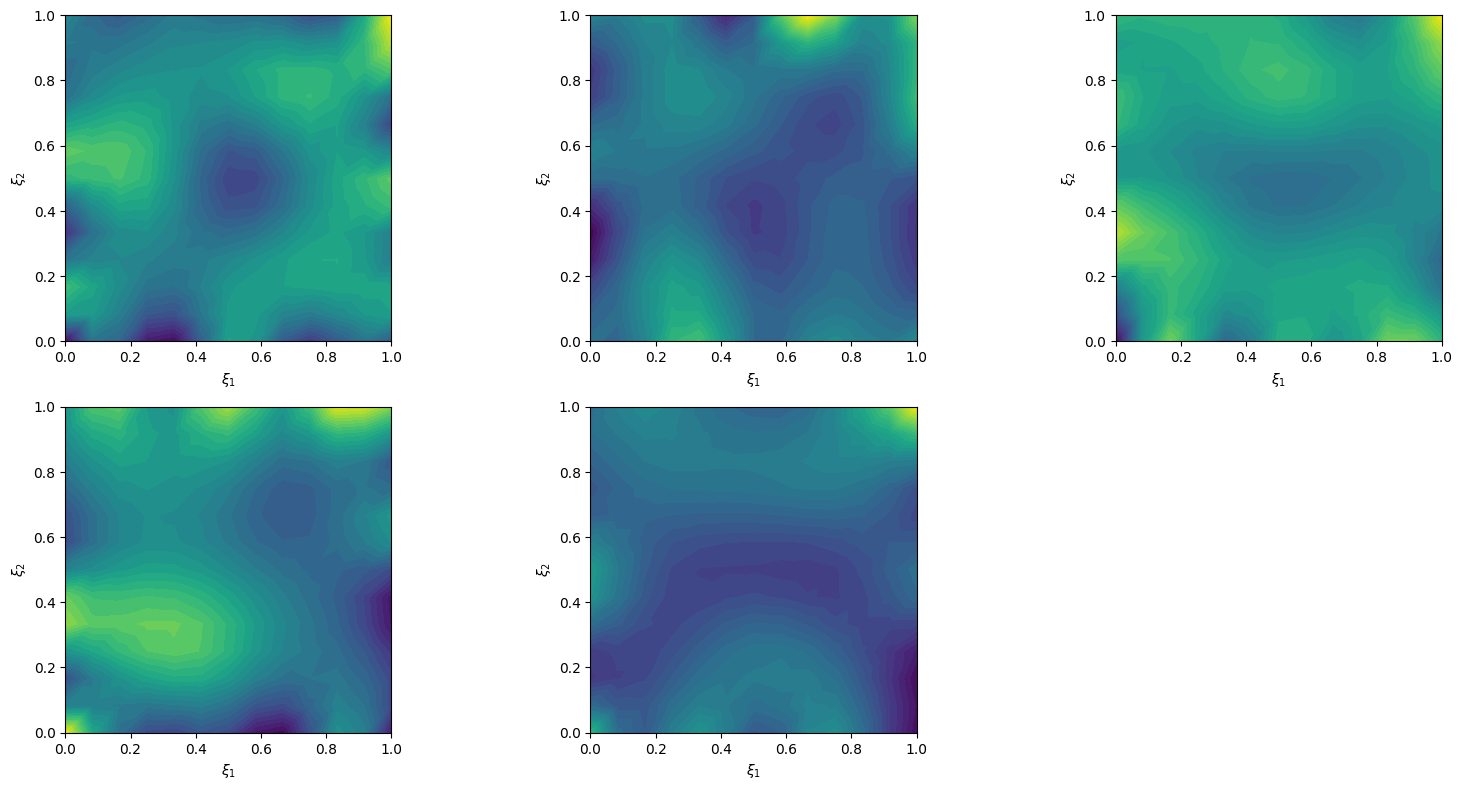

In [16]:
prior_samples = x.sample(5)
prior_samples.plot()

### 2.5. Create exact solution and exact data

We create an exact solution (for simplification in this notebook, the exact solution is created from a prior sample):

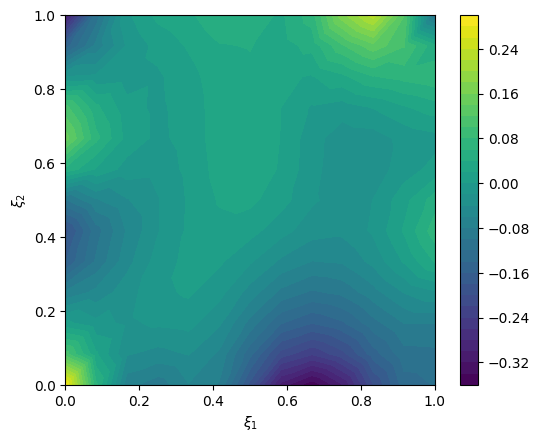

In [17]:
np.random.seed(1)
exact_solution = x.sample()

# plot exact solution
im = exact_solution.plot()
plt.colorbar(im[0])

Create synthesized data that corresponds to the exact_solution

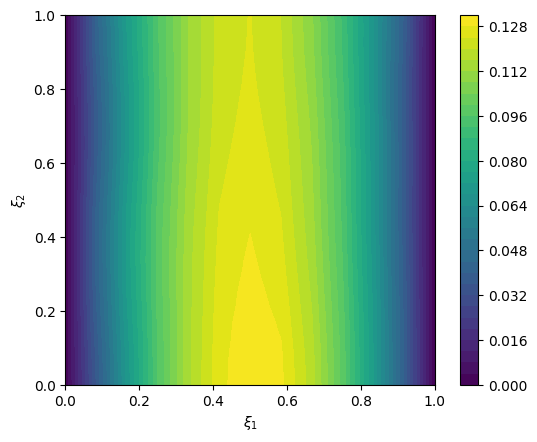

In [18]:
exact_data = cuqi_model(exact_solution)

# plot exact data
im = range_geometry.plot(exact_data)
plt.colorbar(im[0])

### 2.6. Create likelihood and data
We create the data distribution

In [19]:
y = Gaussian(mean=cuqi_model(x), cov=.001**2, geometry=range_geometry)
y

CUQI Gaussian. Conditioning variables ['x'].

And we create the data

In [20]:
y_obs = y(x=exact_solution).sample()

We plot the data

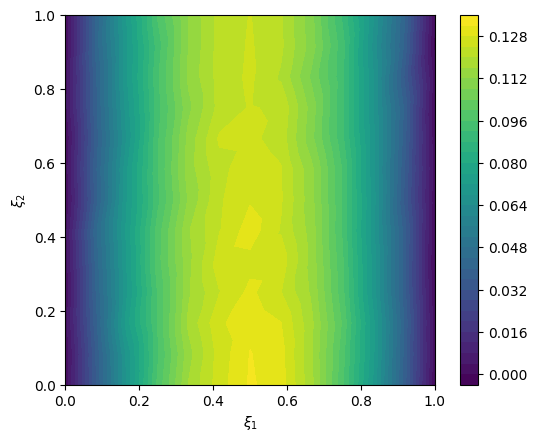

In [21]:
# plot data
im = range_geometry.plot(y_obs)
plt.colorbar(im[0])

We create the likelihood function:

In [22]:
L = y(y=y_obs)

### 2.7. Create the posterior

We create the posterior distribution

In [23]:
cuqi_posterior = Posterior(L, x)

### 2.8. Sample the posterior
Create a [preconditioned Crank-Nicolson (pCN)](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.pCN.html#cuqi.sampler.pCN) sampler

In [24]:
Ns = 100
sampler = pCN(cuqi_posterior)

Sample the posterior

In [25]:
samples_pCN = sampler.sample_adapt(Ns, Nb=10)

 Sample 110 / 110

Average acceptance rate: 0.33 MCMC scale: 0.07609372151299272 



We plot the samples mean (and the exact solution for reference)

Text(0.5, 1.0, 'Exact solution')

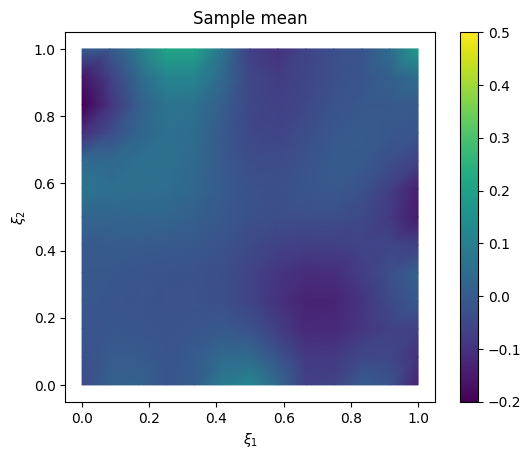

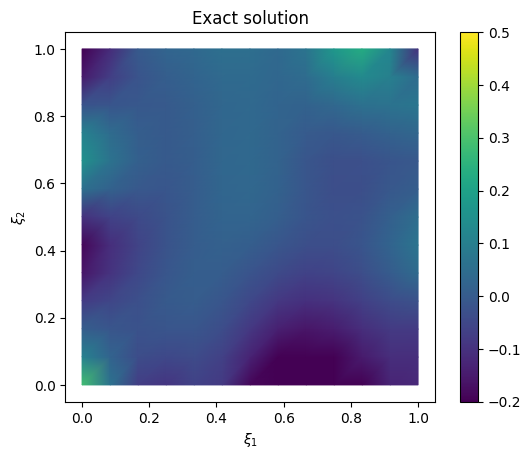

In [26]:
# plot samples mean
im = samples_pCN.plot_mean(vmin=-0.2, vmax=0.5, mode='color')
cb = plt.colorbar(im[0])

# plot the exact solution
plt.figure()
im = exact_solution.plot(vmin=-0.2, vmax=0.5, mode='color')
cb = plt.colorbar(im[0])
plt.title('Exact solution')

We look at the trace plot

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'v6'}>, <Axes: title={'center': 'v6'}>],
       [<Axes: title={'center': 'v11'}>, <Axes: title={'center': 'v11'}>],
       [<Axes: title={'center': 'v12'}>, <Axes: title={'center': 'v12'}>],
       [<Axes: title={'center': 'v19'}>, <Axes: title={'center': 'v19'}>],
       [<Axes: title={'center': 'v20'}>, <Axes: title={'center': 'v20'}>]],
      dtype=object)

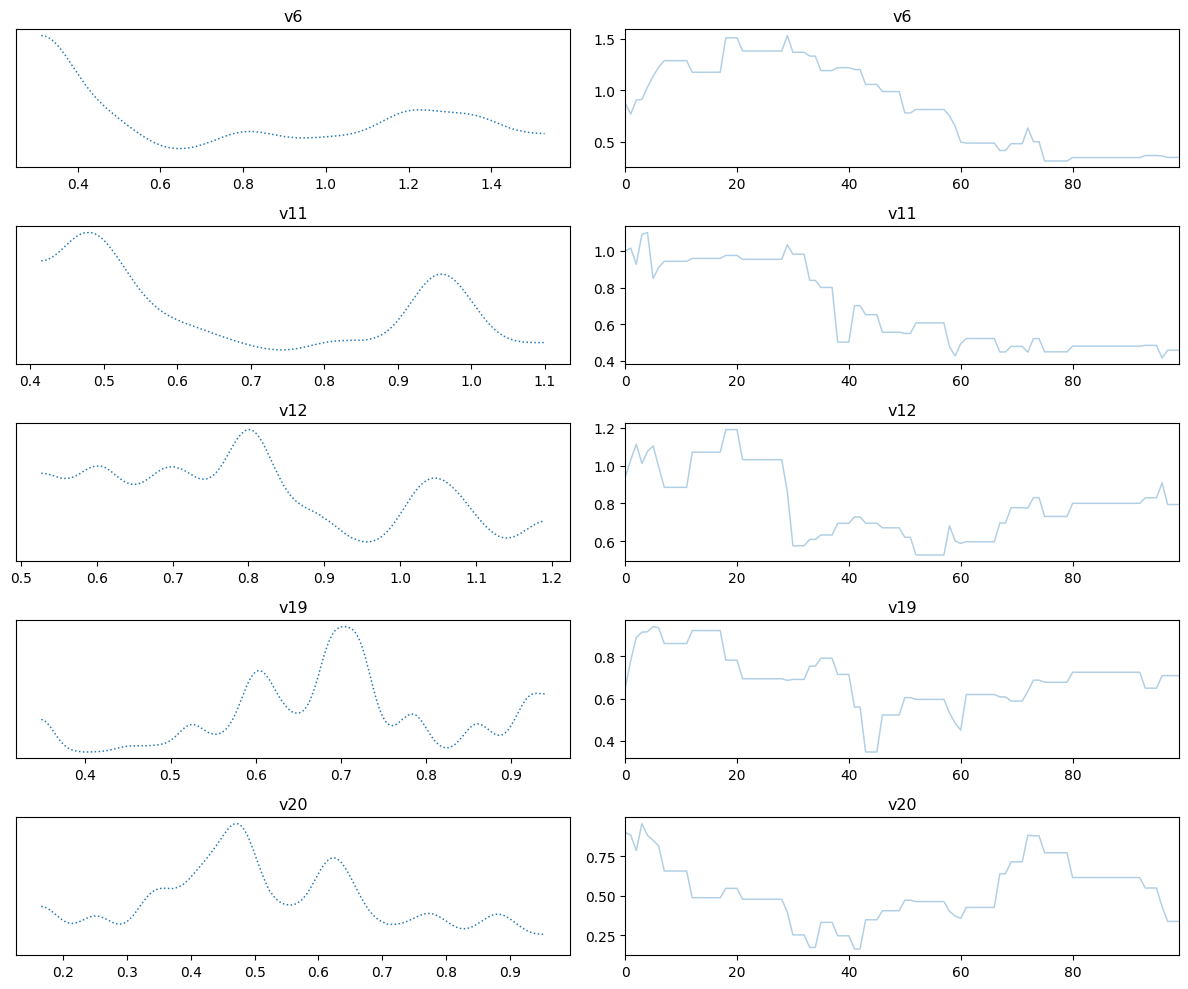

In [27]:
samples_pCN.plot_trace()

We plot the credibility interval

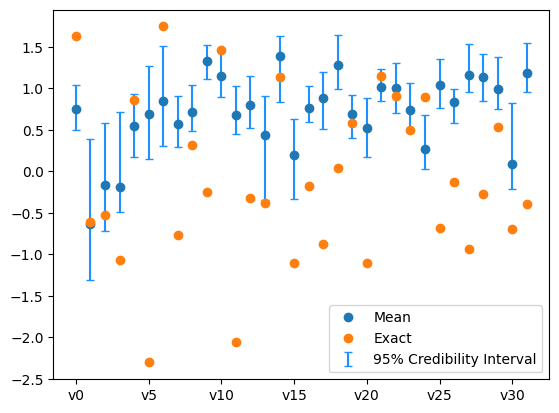

In [28]:
samples_pCN.plot_ci(exact=exact_solution, plot_par=True)
plt.xticks(np.arange(x.dim)[::5],['v'+str(i) for i in range(x.dim)][::5]);

The sampling did not go so well. We need to use a better sampling technique.

## 3. Using gradient-based sampler <a class="anchor" id="gradient_sampling"></a>

### 3.1. The chain rule

We compute the gradient of the log-posterior with respect to the unknown parameter $x$ using the chain rule:
$$\nabla_x \mathrm{log}p_\mathrm{post}(x) \propto \nabla_x \mathrm{log}p_\mathrm{likelihood}(\mathcal{G}(m(x))) + \nabla_x \mathrm{log}p_\mathrm{prior}(x), $$
where $p_\mathrm{likelihood}$ is the likelihood density function, $p_\mathrm{prior}$ is the prior probability density function, $p_\mathrm{post}$ is the posterior probability density function and $m$ is the Matern field.


We have the maps:
- $z := m(x)$, implemented by the domain geometry `MaternKLExpansion`.
- $y := \mathcal{G}(z) $, implemented by the forward model `PDEModel`.


By the chain rule we have (for the likelihood part):

$$ \nabla_x \mathrm{log}p_\mathrm{likelihood}(y) = J_{z,x}^T(x) J_{y, z}^T(z) \nabla_y  \mathrm{log}p_\mathrm{likelihood}(y), $$
where $J_{z,x}$ is the Jacobian of the map $z=m(x)$ with respect to $x$, $J_{y, z}$ is the Jacobian of the map $y=\mathcal{G}(z)$ with respect to $z$ and $\nabla_y  \mathrm{log}p_\mathrm{likelihood}(y)$ is the gradient of the log-likelihood with respect to $y$.

- We use adjoint-based method to compute the matrix vector product $J_{y, z}^T(z)v$ for some given vector $v$.
	- Costs one forward solve and one adjoint solve (cheaper than finite difference approximation)


**This is done automatically by CUQIpy-FEniCS**

  

### 3.1 Set the adjoint problem boundary conditions

To compute the gradient using adjoint based method, we need to define the adjoint problem (which the `PDE` object infers) and derive the adjoint problem boundary conditions.

See: Gunzburger, M. D. (2002). Perspectives in flow control and optimization. Society for Industrial and Applied Mathematics, for adjoint based derivative derivation.

We create the adjoint problem boundary conditions.  

In [29]:
adjoint_dirichlet_bc_expr = dl.Constant(0.0)
adjoint_dirichlet_bc = dl.DirichletBC(solution_function_space,
                                      adjoint_dirichlet_bc_expr,
                                      u_boundary) #adjoint problem bcs

We recreate the `PDE` object to use the adjoint boundary conditions. We then again create the `PDEModel`, the data distribution, and the posterior distribution to use the new `PDE` object.

In [30]:
PDE = SteadyStateLinearFEniCSPDE( 
        form,
        mesh, 
        parameter_function_space=parameter_function_space,
        solution_function_space=solution_function_space,
        dirichlet_bcs=dirichlet_bc,
        adjoint_dirichlet_bcs=adjoint_dirichlet_bc)

cuqi_model = PDEModel(PDE,
                      domain_geometry=domain_geometry,
                      range_geometry=range_geometry)

y = Gaussian(mean=cuqi_model(x), cov=.001**2, geometry=range_geometry)
L = y(y=y_obs)
cuqi_posterior = Posterior(L, x)

### 3.2 Check the gradient correctness at an input $x_\mathrm{test}$
We check the log posterior gradient correctness at an input $x_\mathrm{test}$ by comparing the gradient computed by CUQIpy-FEniCS using adjoint based method and the gradient computed using `scipy` `optimize.approx_fprime` method.

We first create the input vector $x_\mathrm{test}$

In [31]:
# Create x_i
x_test = CUQIarray(np.random.randn(domain_geometry.par_dim), is_par=True, geometry=domain_geometry)

Compute the posterior gradient using CUQIpy-FEniCS


In [32]:
print("Posterior gradient (cuqi.model)")
cuqi_grad = cuqi_posterior.gradient(x_test)


Posterior gradient (cuqi.model)


Compute the approximate gradient using `optimize.approx_fprime`


In [33]:
print("Scipy approx")
step = 1e-11   # finite diff step
scipy_grad = optimize.approx_fprime(x_test, cuqi_posterior.logpdf, step)

Scipy approx


Plot both gradients

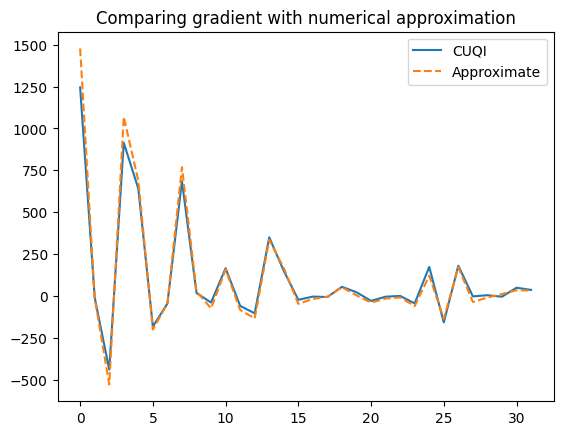

In [34]:
plt.plot(cuqi_grad, label='CUQI')
plt.plot(scipy_grad , '--', label='Approximate')
plt.legend()
plt.title("Comparing gradient with numerical approximation");

### 3.3. Use gradient based sampler (NUTS)

Specify a gradient-based sampler (we use NUTS here)

In [35]:
Ns = 200
sampler = NUTS(cuqi_posterior)

Sample using NUTS (this may take a little while)

In [36]:
samples_NUTS = sampler.sample_adapt(Ns, Nb=5)

Sample 205 / 205


Plot the mean and the exact solution

Text(0.5, 1.0, 'Exact solution')

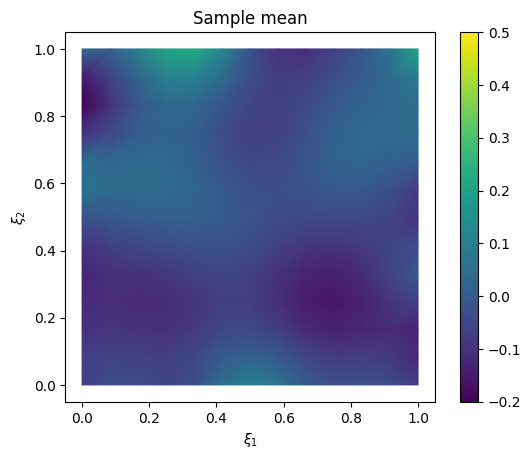

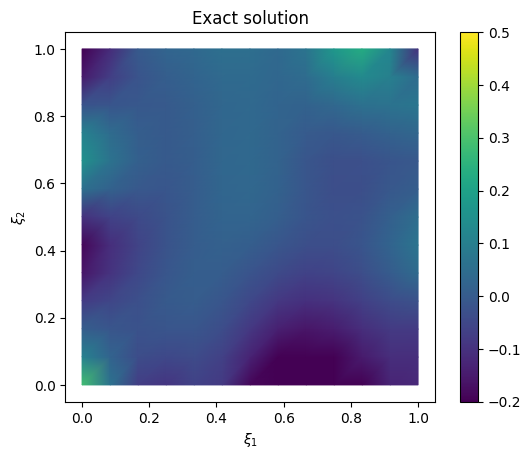

In [37]:
# plot samples mean
im = samples_NUTS.plot_mean(vmin=-0.2, vmax=0.5, mode='color')
cb = plt.colorbar(im[0])

# plot the exact solution
plt.figure()
im = exact_solution.plot(vmin=-0.2, vmax=0.5, mode='color')
cb = plt.colorbar(im[0])
plt.title('Exact solution')

Plot trace

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'v8'}>, <Axes: title={'center': 'v8'}>],
       [<Axes: title={'center': 'v13'}>, <Axes: title={'center': 'v13'}>],
       [<Axes: title={'center': 'v17'}>, <Axes: title={'center': 'v17'}>],
       [<Axes: title={'center': 'v21'}>, <Axes: title={'center': 'v21'}>],
       [<Axes: title={'center': 'v26'}>, <Axes: title={'center': 'v26'}>]],
      dtype=object)

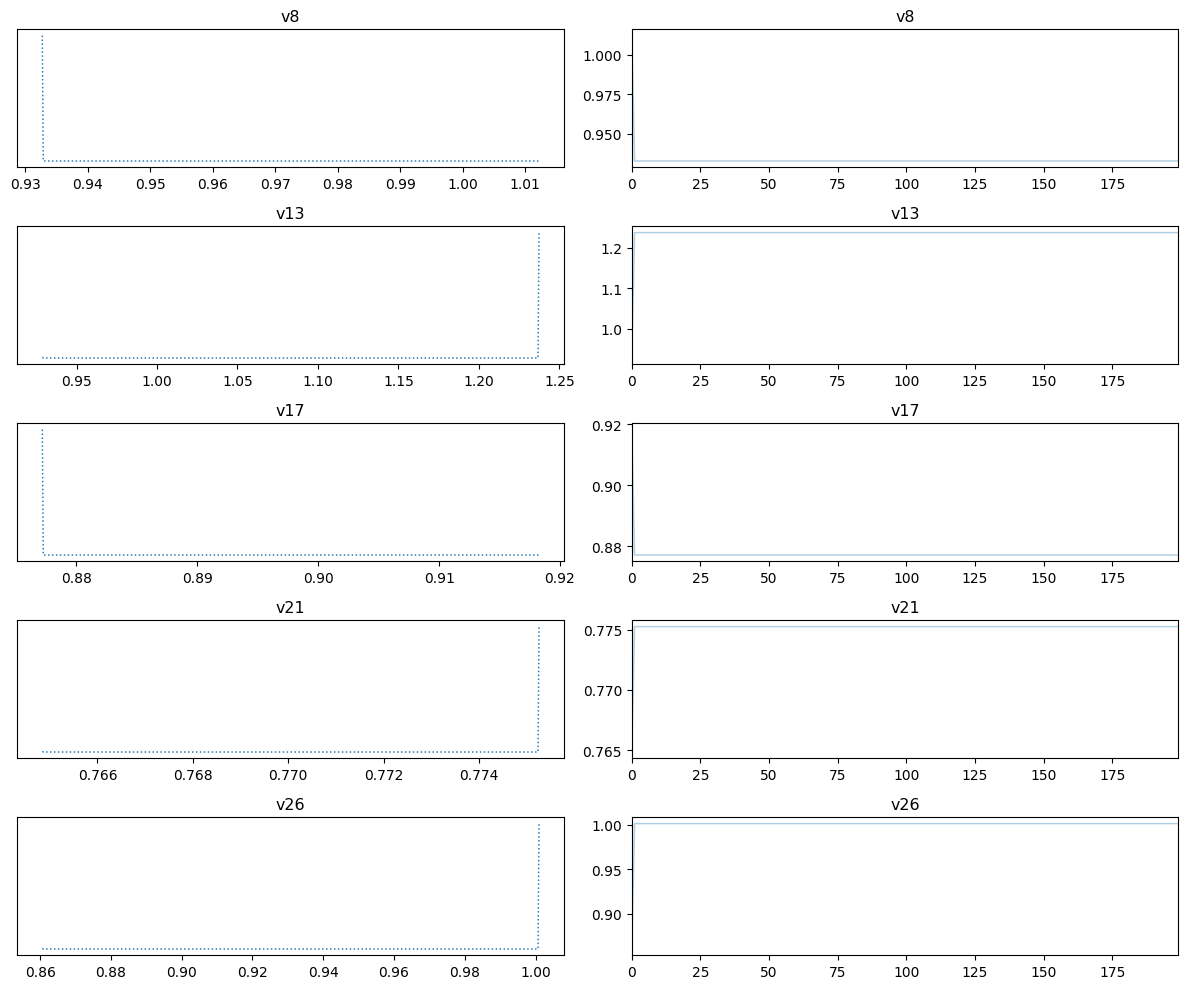

In [38]:
samples_NUTS.plot_trace()

We also plot the credibility interval

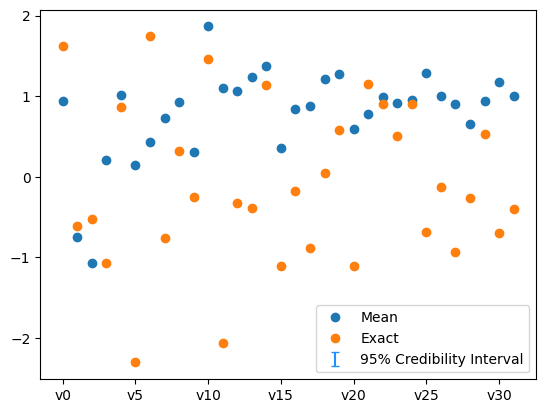

In [39]:
samples_NUTS.plot_ci(exact=exact_solution, plot_par=True)
plt.xticks(np.arange(x.dim)[::5],['v'+str(i) for i in range(x.dim)][::5]);

Now the sampling has gone better. This is because we utilized gradient information of the problem.

#### ★ Try yourself (optional):  

- What do you notice by comparing the trace plots of the pCN samples and the NUTS samples, and comparing the samples mean and the exact solution in both cases.
- Compute the effective samples size (ESS) for each case.
- In this example, we build FEniCS code PDE ourselves. CUQIpy-FEniCS also provides test problems. Copy-paste the code script you find on [CUQIpy-FEniCS main page](https://github.com/CUQI-DTU/CUQIpy-FEniCS) and run the code here. 


In [40]:
# Your code here

